## Trend Analysis and forecasting with Prophet

In [154]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import display

from src.data_matching import match_data
from src.get_data import get_madrid_data, get_weather_df, get_air_quality_df, get_traffic_df
from src.models.train_model import train_prophet_model, train_clasp_model
from src.models.prophet_utils import get_trend_deviation_from_changepoint
from src.visualization import visualize_prophet_results, visualize_clasp_results
import os, logging
from itertools import product

from src.models.prophet_utils import get_changepoints_from_model, make_metrics_from_prophet_results

%matplotlib inline
pd.options.plotting.backend = "plotly"

# set matplotlib style
plt.style.use("seaborn-white")

logging.getLogger('prophet').setLevel(logging.WARNING)
logging.basicConfig(level=logging.INFO)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
aq_df = get_air_quality_df("../01-data")
aq_df.columns = aq_df.columns.str.replace("µ","u")
weather_df = get_weather_df("../01-data").dropna()
predict_df = match_data(aq_df, weather_df)

predict_df = predict_df.set_index(
        ["zone","time"]
    ).groupby([pd.Grouper(level='zone'), 
                pd.Grouper(level='time', freq='1D')]
    ).mean().reset_index()

Predicted trend of NO2 is on average +3.63% away from the real trend before the changepoint and +38.63% after the changepoint


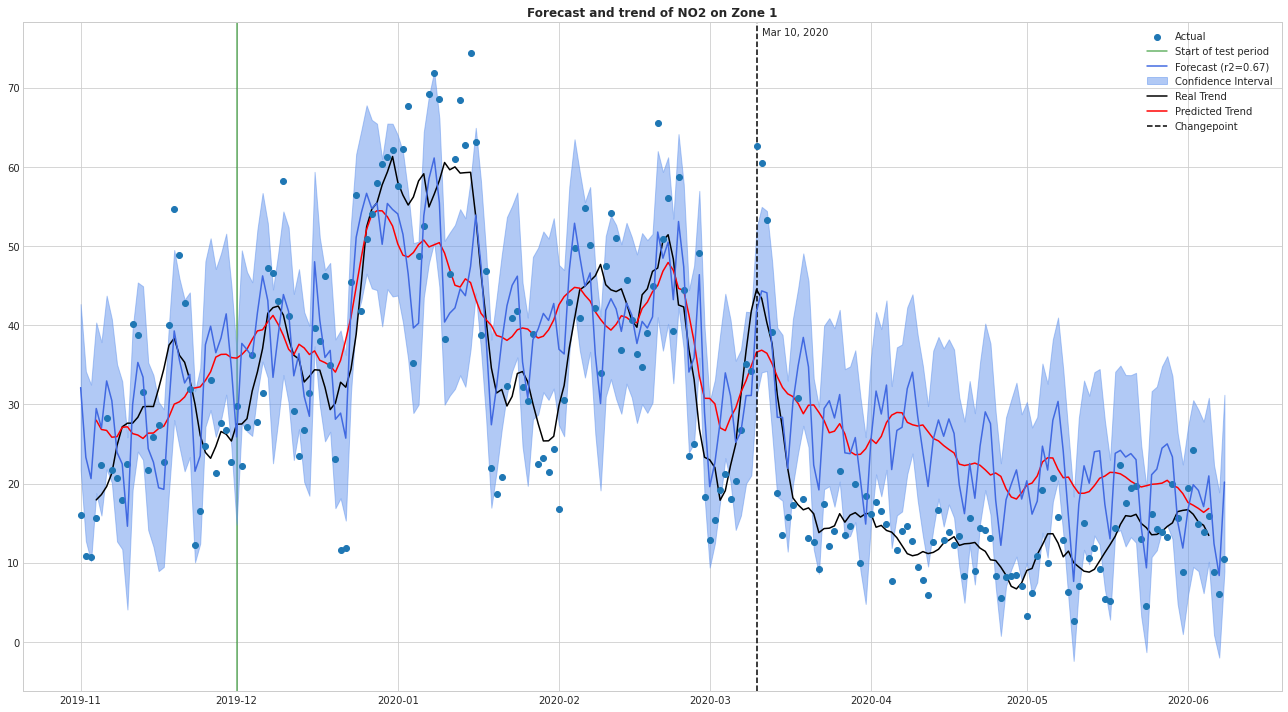

In [198]:
import matplotlib as mpl
mpl.rcParams['axes.titleweight'] = 'bold'
mpl.rcParams['axes.titlesize'] = 'large'
mpl.rcParams['axes.facecolor'] = 'white'

plt.style.use("seaborn-whitegrid")

zone = 1
pollutant = "no2_ug_m3"

deviation_percent_pre,deviation_percent_post = get_trend_deviation_from_changepoint(
    predict_df,
    pollutant=pollutant,
    location=zone,
    start="2010-01-01",
    end="2021-11-01",
    changepoint="2020-03-10",    
    eval_delta=pd.Timedelta(days=90),
    eval_start = "2019-12-01",
    pretrend_start = pd.Timedelta(days=30),
    regressors=weather_df.columns.drop(["time"]),
    # title = f"Forecast and trend of {pollutant.split('_')[0].upper()} on {location_by.capitalize()} {location}"
)
print(f"Predicted trend of {pollutant.split('_')[0].upper()} is on average {deviation_percent_pre:+.2%} away from the real trend "\
    f"before the changepoint and {deviation_percent_post:+.2%} after the changepoint")


--------

Extract changepoints and train a prophet model that predicts 3 months ahead in the future for each pollutant and zone.

In [2]:
madrid_df = get_air_quality_df("../01-data", meteo_normalized=True)
madrid_df = madrid_df.set_index(
        ["zone","time"]
    ).groupby([pd.Grouper(level='zone'), 
                pd.Grouper(level='time', freq='1D')]
    ).mean().reset_index()

In [192]:
pd.Timedelta(0)

Timedelta('0 days 00:00:00')

In [ ]:
# Training parameters

start = "2010-01-01"
end = "2020-10-30"
indicators = "no2_ug_m3","pm10_ug_m3","pm25_ug_m3","o3_ug_m3"
location_by = "zone"

## ClaSP
n_changepoints = 3

## Prophet
eval_delta = pd.Timedelta(days=90)
changepoints_threshold = .75
prophet_model_params = {
    "changepoint_prior_scale": 0.4,
    "changepoint_range": 0.9,
    "seasonality_mode": "additive",
    "seasonality_prior_scale": 10,
    "holidays_prior_scale": 6,
}
savefigs = True # Save figures to disk
visualize = True

# Dataframe to use for training/predictions
df = madrid_df.loc[(madrid_df.time.between(start,end))]
result_metrics = [] # list to store metrics for each model/evaluation
for indicator,location in product(indicators,df[location_by].unique()):
    location_df = df[(df[location_by]==location)]
    if (~location_df.loc[:,indicator].isnull()).sum() < 100:
        # Skip if there are not enough data points for this indicator
        print("Not enough data points. Skipping",indicator,location)
        continue
    # Train clasp and get the changepoints
    clasp_results = train_clasp_model(
        df,
        y=indicator,
        location=location,
        location_by=location_by,
        n_changepoints=n_changepoints,
        train_start=start,
        train_end=end,
        verbose=False
    )
    changepoints_df = clasp_results.changepoints_df
    changepoints = changepoints_df.time.values
    for cp in changepoints:
        if np.abs(cp-df.time.min()).days < 30 or np.abs(cp-df.time.max()).days < 30:
            print(f"Not enough data points at changepoint {cp}. Skipping",indicator,location)
            continue
        results = train_prophet_model(
                    location_df, indicator,
                    eval_start=cp,
                    eval_end = cp+eval_delta,
                    verbose=False,
                    **prophet_model_params
        )
        metrics = make_metrics_from_prophet_results(results,changepoints_threshold)
        result_metrics.append({"indicator": indicator,"location": location,"eval_start":cp,"eval_end":cp+eval_delta,**metrics})
        if visualize:
            fig, axes = visualize_prophet_results(
                results,changepoints_threshold=changepoints_threshold,
                ax_titles=[
                    f"Actual recorded values of {indicator} for {location_by} {location}",
                    f"Changepoints and Forecast of {indicator} for {location_by} {location} from {pd.to_datetime(cp).strftime('%b-%d-%Y')} to {(cp+eval_delta).strftime('%b-%d-%Y')}"
                ],
                nrows=2
            )
        if visualize and savefigs:
            # Save figure to disk
            start_str = pd.to_datetime(start).strftime("%Y.%-m.%-d")
            plt.savefig(f"../reports/figures/prophet/prophet_forecast_{start_str}_{indicator}_{location_by}_{location}-meteonorm.png")
            fig.show()
results_df = pd.DataFrame(result_metrics)

In [27]:
results_df.to_csv("../reports/prophet_results-meteonorm.csv",index=False)
results_df

,indicator,location,eval_start,eval_end,r2,mse,mae,mean_error,cp_threshold,cp_prior_scale,cp_range,seasonality_mode,seasonality_prior_scale,holidays_prior_scale,cps_detected
0,no2_ug_m3,1,2018-07-31,2018-10-29,-3.144045,0.224266,0.397170,-0.366607,0.75,0.4,0.9,additive,10,6,"[2014-08-29, 2014-12-28]"
1,no2_ug_m3,1,2020-05-25,2020-08-23,-22.579072,11.260531,3.039813,-3.039813,0.75,0.4,0.9,additive,10,6,"[2015-02-25, 2015-05-20, 2015-08-12, 2016-01-2..."
2,no2_ug_m3,1,2014-06-23,2014-09-21,-0.493357,0.066431,0.202018,-0.120576,0.75,0.4,0.9,additive,10,6,[]
3,no2_ug_m3,2,2015-06-13,2015-09-11,-0.758089,0.112184,0.267469,-0.208316,0.75,0.4,0.9,additive,10,6,[]
4,no2_ug_m3,2,2019-02-02,2019-05-03,-1.141721,1.451584,0.985881,0.982739,0.75,0.4,0.9,additive,10,6,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,o3_ug_m3,5,2016-06-21,2016-09-19,-23.065921,4.230208,1.778059,-1.775814,0.75,0.4,0.9,additive,10,6,[]
64,o3_ug_m3,6,2014-06-08,2014-09-06,-0.834766,0.663375,0.653526,0.507761,0.75,0.4,0.9,additive,10,6,[]
65,o3_ug_m3,7,2018-12-25,2019-03-25,-0.048906,0.687400,0.691452,-0.648949,0.75,0.4,0.9,additive,10,6,[]
66,o3_ug_m3,7,2015-06-26,2015-09-24,-6.372932,1.685179,1.135780,1.117637,0.75,0.4,0.9,additive,10,6,[]


Now obtaining the changepoints with the meteorologically-normalized data but fitting the forecast model with the unnormalized data

In [ ]:
results_df.to_csv("../reports/prophet_results-meteonorm.csv",index=False)
results_df

""


In [ ]:
display(results.eval_metrics_df)
percent_diff = (results.eval_metrics_df.mean_diff.score/results.test_df.y.mean())*100
print("The prediction was on average {:+.2f}%% off".format(percent_diff))

,mse,mae,r2,mean_diff
score,105.937276,7.90801,0.457057,2.412873


The prediction was on average +9.12%% off


In [ ]:
# Inspect model betas
m = results.model
component_cols = m.train_component_cols.columns
regressor_cols_inds = range(len(component_cols)-20,len(component_cols)) #np.where(component_cols.columns.isin(weather_df.columns.drop("time")))[0]
regressor_betas = m.params["beta"][0,regressor_cols_inds]
print("\n".join(f"{col}: {beta:.3f}" for col,beta in zip(component_cols[regressor_cols_inds],regressor_betas)))